# Math 124 - Programming for Mathematical Applications
UC Berkeley, Spring 2024

## Project 5 - Neural Networks for Character Recognition

Due Friday, April 26

In [1]:
using PyPlot, Random, LinearAlgebra, Optim   # Packages needed

### Description

In this project, you will implement an artificial neural network for *Optical Character Recognition* (OCR). We will use a so-called *Multilayer Perceptron* (MLP) with a single hidden layer.

### Preliminaries

First we define the characters that we will use to train the network. Each character will be an image
of size 7-by-6, represented as a vector of 42 values,
and we will use the 4 characters "MATH". In the network, these characters will be
encoded using two output variables $y = (y_1,y_2)$, where $y=(0,0)$ represents "M", $y=(0,1)$
represents "A", and so on. The code below defines these images and returns the following variables:

* `training`, size 42-by-4 array containing the 42 pixel-values for each of the 4 characters
* `target`, size 2-by-4 array containing the desired output for each of the 4 characters
* `mapstr`, the string "MATH" which is the characters that each `target` output corresponds to

In [2]:
charstr = """
          OOOOOO  OOOOOO  OOOOOO  OO..OO
          OOOOOO  OOOOOO  OOOOOO  OO..OO
          O.OO.O  OO..OO  ..OO..  OO..OO
          O.OO.O  OO..OO  ..OO..  OOOOOO
          O....O  OOOOOO  ..OO..  OO..OO
          O....O  OO..OO  ..OO..  OO..OO
          O... O  OO..OO  ..OO..  OO..OO
          """

training = reshape(collect(charstr), :, 7)
training = Int.(training[[1:6;9:14;17:22;25:30],:] .== 'O')
training = reshape(training', 7*6, 4)
target = [0 0; 0 1; 1 0; 1 1]'
mapstr = "MATH";

We also define the plotting function below, which takes an array `images`
with 42 rows and one column for each image, and shows the images in a grid:

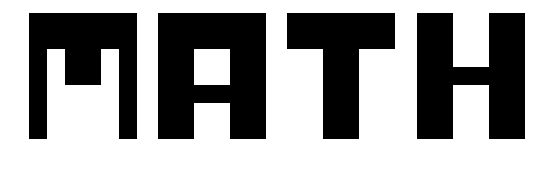

In [3]:
function plot_chars(images)
    gray()
    n_images = size(images,2)
    for j = 1:n_images
        subplot(ceil(Int, n_images/4), 4, j)
        im = 1 .- reshape(images[:,j], 7, 6)
        imshow(im); axis("off");
    end
end
plot_chars(training)

### Problem 1 - Generating noisy test characters

To test our trained OCR code, we need noisy or perturbed characters. Here we will artificially produce
these by modifying the true character images in `training`.

Write a function `make_testdata(training)` which returns an array `testdata` of size 42-by-20.
The first 4 images (columns) of `testdata` are identical copies of the `training` array. Generate the next
4 images by randomly choosing 2 pixels in each training image, and flip their values (that is,
0 becomes 1, 1 becomes 0). For the next 4 images you choose 2x2=4 random pixels to flip, then
2x3=6 pixels, and finally 2x4=8 pixels. This gives a total of 16 new perturbed images, and 20 columns
total including the original images.

Plot your test data using the commands below. This should show a 5-by-4 array of successively
worse letters MATH in each row.

In [ ]:
testdata = make_testdata(training);
plot_chars(testdata)

### Machine learning using a multilayer perceptron

Our network is illustrated below. The input $x=(x_1,\ldots,x_{42})$ is in our case an image represented as a vector of length 42, and the output $y=(y_1,y_2)$ is a vector of length 2, with the predicted character
encoded as described above.

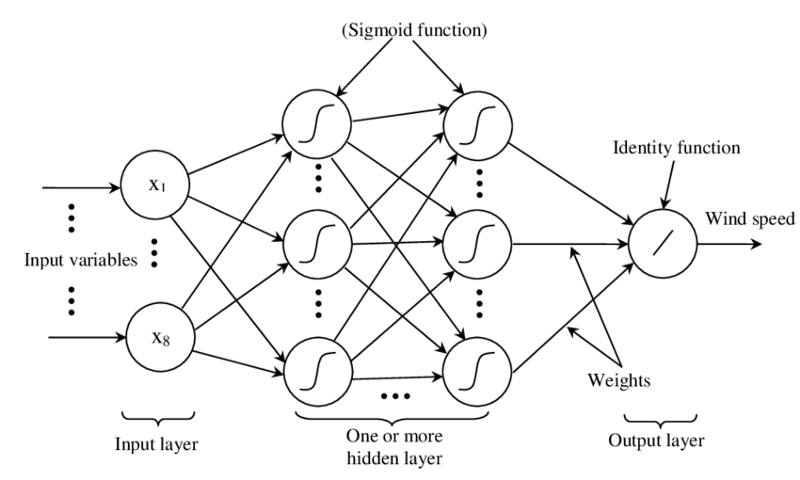
(by V. Palaniappan, https://medium.com/engineer-quant/multilayer-perceptron-4453615c4337)

Here, the *sigmoid function* is defined by

$$
\sigma(x) = \frac{1}{1 + e^{0.5 - x}}
$$

The *weights* (that is, the arrows between the layers) can be represented in a linear form as a matrix multiplication. The goal of the training is to determine these weights, that is, the entries of the matrices.

We will use a hidden layer with 10 neurons. This means that the first layer can be written as
a matrix-vector product $Vx$ for some weight matrix $V$ of size 10-by-42. Next we apply the
sigmoid function (element-wise) to get $r=\sigma(Vx)$, apply another weight matrix $W$ of size
2-by-10, and finally
apply the sigmoid function again to predict the output $y$. In total this gives $10\cdot 42
+ 2\cdot 10 = 440$ weights that need to be determined during the training. The entire
network can be written in a compact form as

$$
y(x) = \sigma(W\sigma(Vx))
$$

We will train our network by solving the following optimization problem:
Find $V\in \mathbb{R}^{10\times 42}$, $W\in \mathbb{R}^{2\times10}$ that
minimize the following so-called *misfit function*

$$
E(V,W) = \frac12 \sum_{j=1}^4 \|y(x_j) - t_j\|_2^2
$$

Here, $x_j$ is the $j$th training vector (from the `training` array),
$t_j$ is the desired target output for the input $x_j$ (from the `target` array),
and $y(x)$ is the network described above.


### Stochastic Gradient Descent training

Finding the true gradient of $E$ is somewhat involved, and instead we will use
the so-called Stochastic Gradient Descent method. At each iteration, we pick:

* A random number $j\in \{1,2,3,4\}$ to decide which training vector $x_j$ and
  target output $t_j$ to use
* A random number $k\in \{1,2\}$ to decide which component of the vector $y(x_j)-t_j$
  to consider
  
We then only compute the gradient direction for the part of $E(V,W)$ that contribute
to output $k$ for training vector $j$. The gradient calculations get simplified with
these assumptions, and they can be computed with the following sequence of computations:

$$
\begin{align*}
r &= \sigma(Vx_j) && \text{column-vector (matrix-vector product)} \\
y &= \sigma(W_k \cdot r) && \text{scalar (dot-product, $W_k$ is $k$th row of $W$)} \\
q &= (y - t_{kj}) y (1 - y) && \text{scalar ($t_{kj}$ is component $k$ of $t_j$)} \\
u &= W_k^T r (1 - r) && \text{column-vector (all products are element-wise)} \\
\nabla_{W_k} E(V,W) &= q r^T  && \text{row-vector (scalar times row-vector)}  \\
\nabla_V E(V,W) &= q u x_j^T && \text{matrix (scalar times outer product)}
\end{align*}
$$

Using these gradients, we update $V$ and the $k$th row of $W$ using standard gradient descent iterations
for a given stepsize $\alpha$.


### Problem 2 - Training using SGD

Implement a function 

```julia
function train_sgd(; maxiter=10000, rate=1)
```

which initializes $V,W$ to normal-distributed random numbers and performs `maxiter`
stochastic gradient descent iterations as described above. Use the step-size $\alpha$ set to `rate` (the
so-called *learning rate*). The function returns $V,W$, and can be tested using the code below.

In [ ]:
V,W = train_sgd()

### Problem 3 - Predict output for noisy characters

We can now apply the trained network $V,W$ to the noisy characters in
`testdata`, and see how well they match. We do this by simply computing
$y(x_j)$ for each image $x_j$ in `testdata`, rounding the outputs $y_1,y_2$
to integers, and mapping the four possibilities to the letters
in `mapstr`.

Write a function `predict(testdata, V, W)` which performs these operations,
and returns a 5-by-4 character array with the predicted characters. The
ideal output would be 5 rows of `'M', 'A', 'T', 'H'`, but we do not of course
expect to be perfect for the highly noisy cases.

In [ ]:
plot_chars(testdata)
predict(testdata, V, W)

### Problem 4 - True gradient descent using the `Optim` package

Since the `Optim` package can perform automatic differentiation, we can try to solve
the optimization problem using true gradient descent. Write a function `train_optim()`
which does this and returns $V,W$ like before. Use the solver `GradientDescent()`,
and remember to set `autodiff=:forward`.

One tricky thing with this is that `optimize` expects a single input vector $x$,
but we have two matrices $V,W$. This is a quite common problem, and you can get
around it by converting the 420+20=440 numbers in $V,W$ to a vector. In the
objective function, you also have to convert back to matrices in order to
evaluate the misfit function $E(V,W)$.

Run your function, then predict the output using the resulting network $V,W$ with the code below.

In [ ]:
plot_chars(testdata)
V,W = train_optim()
predict(testdata, V, W)